# Initializing an InfluxDB Client

Setting up basic parameter for influxDB client. 

In [1]:
from influxdb_client import InfluxDBClient
import warnings

# Initialize the InfluxDB client
token = "fP-GBq8Z1wZE7iW8qFBuxVy-ArVP9TqVec0naJ77XLECiwSr82aRXqvo3ylXZqU_2ad2vxWGcMoMbl3PXqAZ7A=="
server_url = "http://140.112.12.62:8086"
client = InfluxDBClient(url=server_url, token=token)
org = "NTUCE"
query_api = client.query_api()

# Disable influxdb pivot warning
import warnings
from influxdb_client.client.warnings import MissingPivotFunction
warnings.simplefilter("ignore", MissingPivotFunction)

### Query drop size distribution from WS100.
WS100 have 12 classes of dropsize.  
Moreover, it can detect hail, drizzle and snow particle.  


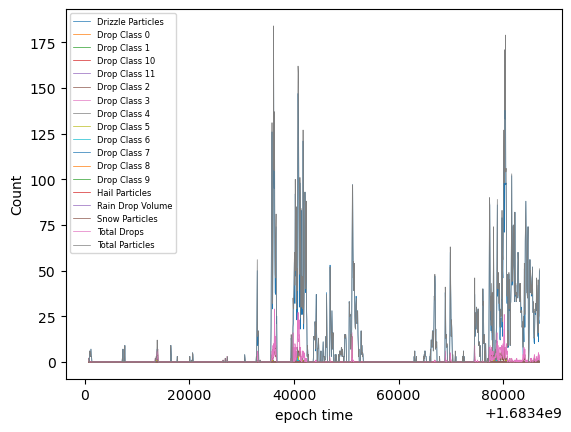

In [22]:
import matplotlib.pyplot as plt
import numpy as np

with open("flux/WS100_dsd.flux", "r") as fluxfile:
    query_str = fluxfile.read()
    drops = query_api.query_data_frame(org="NTUCE", query = query_str)
    # Drop useless columns
    drops.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    drops.set_index("_time", inplace=True)
    # Fill missing timestamp with default value value 0
    drops = drops.reindex(list(range(drops.index.min(), drops.index.max(), 60)), fill_value=0)

plt.rcParams['legend.fontsize'] = 6
plt.plot(drops, linewidth=0.5)
plt.xlabel("epoch time")
plt.ylabel("Count")
plt.legend(drops.columns)

### Query precipitation parameters from WS100.
WS100 gather precipitation intensity and temperature.

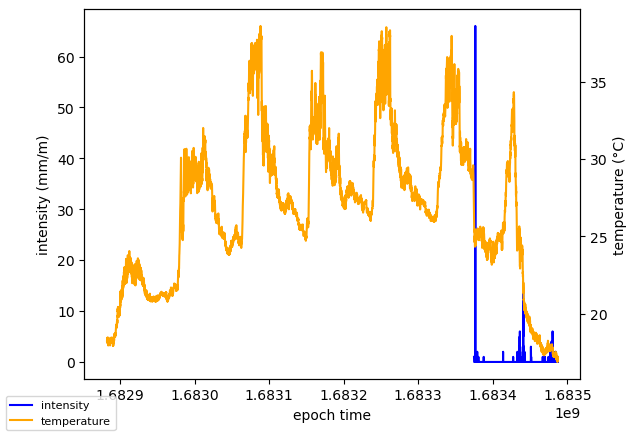

In [26]:
# Get intensity data
with open("flux/WS100_intensity.flux") as fluxfile:
    intensity_query_str = fluxfile.read()
    intensity = query_api.query_data_frame(org="NTUCE", query = intensity_query_str)
    # Drop useless columns
    intensity.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    intensity.set_index("_time", inplace=True)
    # Fill missing timestamp with default visibility value 20000
    intensity = intensity.reindex(list(range(intensity.index.min(), intensity.index.max(), 60)), fill_value=0)

with open("flux/WS100_temp.flux") as fluxfile:
    temp_query_str = fluxfile.read()
    temp = query_api.query_data_frame(org="NTUCE", query = temp_query_str)
    # Drop useless columns
    temp.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    temp.set_index("_time", inplace=True)

fig, ax1 = plt.subplots()
plt.rcParams['legend.fontsize'] = 8

# Plot intensity
ax1.plot(intensity.index, intensity["_value"], color="blue", label="intensity")
ax1.set_xlabel("epoch time")
ax1.set_ylabel("intensity (mm/m)")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot temperature
ax2.plot(temp.index, temp["_value"], color="orange", label="temperature")
ax2.set_ylabel("temperature (°C)")

fig.legend(loc="lower left")
plt.show()


### Query machine status data from WS100.
WS100 provides heater temperature and supply voltage.  

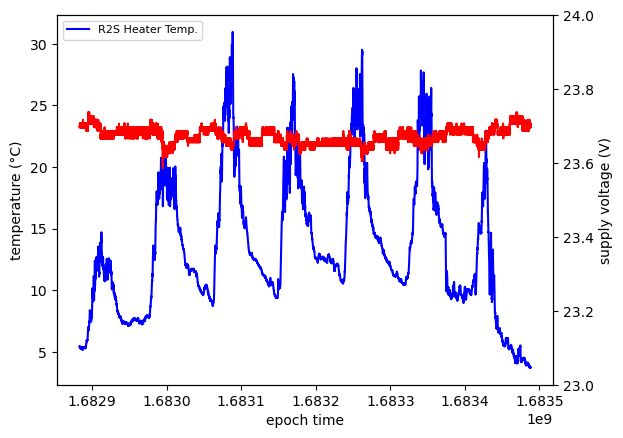

In [41]:
with open("flux/WS100_machine.flux") as fluxfile:
    machine_query_str = fluxfile.read()
    machine = query_api.query_data_frame(org="NTUCE", query = machine_query_str)
    # Drop useless columns
    machine.drop(columns=["result", "table"], inplace=True)
    # Reindex the dataframe with time column
    machine.set_index("_time", inplace=True)

fig, ax1 = plt.subplots()
plt.rcParams['legend.fontsize'] = 8

# Plot heater temperature
ax1.plot(machine.index, machine["R2S Heater Temp."], color="blue", label="R2S Heater Temp.")

ax1.set_xlabel("epoch time")
ax1.set_ylabel("temperature (°C)")

# Create a second y-axis
ax2 = ax1.twinx()

# Plot supply voltage
ax2.plot(machine.index, machine["Supply Voltage"], color="red", label="Supply Voltage")
ax2.set_ylabel("supply voltage (V)")
ax2.set_ylim(23, 24)

ax1.legend(loc="upper left")
plt.show()
